# Breast Cancer data exploratory data analysis and prediction using logistic regression

Vanshika Mishra

### Agenda :


To carry out and exploratory data analysis of the various features related to a person being classified as having /not breast cancer in terms of tumor malignancy ,with 1 being classfied as malignant(cancerous) and 0 being benign(non cancerous)

### This notebook contains the following:


    
The Data - Exploratory Data Analysis

The Variables - Feature Selection

The Model - Building a Logistic Regression Model

The Prediction - Making Predictions with the Model

### Attribute information

id

Name of the patient

diagnosis: 1 = malignant, 0 = benign
    
radius: distances from center to points on the perimeter
    
texture: standard deviation of gray-scale values
    
perimeter

area

smoothness: local variation in radius lengths
    
compactness: perimeter^2 / area - 1.0
    
concavity: severity of concave portions of the contour
     
symmetry

fractal dimension: "coastline approximation" - 1



#### Vanshika Mishra
June 2020

In [146]:
# Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.metrics import plot_confusion_matrix

warnings.filterwarnings('ignore') #ignore warning messages 

In [147]:
df=pd.read_csv("https://raw.githubusercontent.com/mokaiser/breast-cancer-diagnosis-a1/master/breastcancer.csv")

In [148]:
df.head()

,id,name,radius,texture,perimeter,area,smoothness,compactness,concavity,symmetry,fractal_dimension,age,diagnosis
0,ID842302,Glynnis Munson,NaN,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.2419,0.07871,35,1
1,ID842517,Lana Behrer,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.1812,0.05667,27,1
2,ID84300903,Devondra Vanvalkenburgh,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.2069,0.05999,31,1
3,ID84348301,Glory Maravalle,NaN,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.2597,0.09744,49,1
4,ID84358402,Mellie Mccurdy,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.1809,0.05883,20,1


In [149]:
#Dropping columns that wouldnt be vital to the analysis or the prediction model like the id and name of patient
df.drop(['name','id'],axis=1,inplace=True)

In [114]:
df.shape

(569, 11)

We have 569 rows and 11 Columns

In [115]:
df.dtypes

radius               float64
texture              float64
perimeter            float64
area                 float64
smoothness           float64
compactness          float64
concavity            float64
symmetry             float64
fractal_dimension    float64
age                    int64
diagnosis              int64
dtype: object

All the data types seem appropritate for each feature

In [150]:
df.describe()

,radius,texture,perimeter,area,smoothness,compactness,concavity,symmetry,fractal_dimension,age,diagnosis
count,498.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.326635,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.181162,0.062798,39.467487,0.372583
std,3.506881,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.027414,0.007060,13.604683,0.483918
min,7.760000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.106000,0.049960,16.000000,0.000000
25%,11.817500,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.161900,0.057700,27.000000,0.000000
50%,13.465000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.179200,0.061540,40.000000,0.000000
75%,16.155000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.195700,0.066120,52.000000,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.304000,0.097440,62.000000,1.000000


Looking for null values

In [117]:
df.isnull().sum()

radius               71
texture               0
perimeter             0
area                  0
smoothness            0
compactness           0
concavity             0
symmetry              0
fractal_dimension     0
age                   0
diagnosis             0
dtype: int64

There are null vaues in the radius column and hence we will compute the average radius for both benign and malignant tumor and then replace the null values with the respective average values for both tumor types.

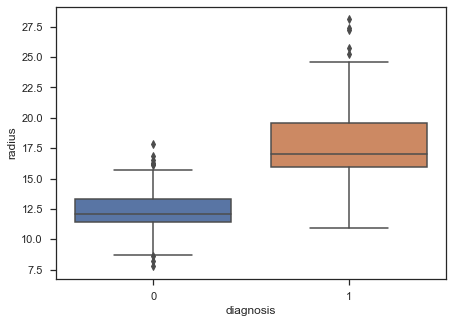

In [186]:
plt.figure(figsize = (7,5))
sns.boxplot(x='diagnosis',y='radius',data=df)


Women with benign(0) tumor have smaller radius 

Women with malignant(1) tumor have comparitively bigger radius

In [152]:
#Calculating average radius for the two tumor types
radius=df.groupby('diagnosis')['radius'].mean().to_frame().reset_index()
radius

,diagnosis,radius
0,0,12.340825
1,1,17.896629


In [153]:
#Creating function to replace null values in radius column in accordance with the diagnosis column

def impute_radius(cols):
    radius = cols[0]
    diagnosis = cols[1]
    
    # if value in radius column is null
    if pd.isnull(radius):
        
        # if woman is diagnosed with breast cancer
        if diagnosis == 1:
            return 17
        # if woman was not diagnosed with breast cancer
        else:
            return 12
    # when value in radius column is not null
    else:
        # return that same value
        return radius

In [154]:
df['radius'] = df[['radius', 'diagnosis']].apply(impute_radius, axis = 1)

Looking at how many are malignant and benign cases in the dataset

Text(0.5, 1.0, 'No. of Cases')

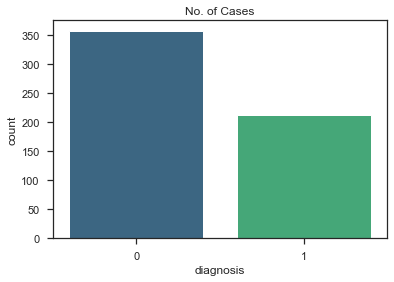

In [155]:
sns.countplot(x='diagnosis',data=df,palette='viridis')
plt.title("No. of Cases")

We have more benign labelled tumors than malignant

In [157]:
benign,malignant=df['diagnosis'].value_counts()
print("No of benign Cases:",benign)
print("No of Malignant Cases",malignant)


No of benign Cases: 357
No of Malignant Cases 212


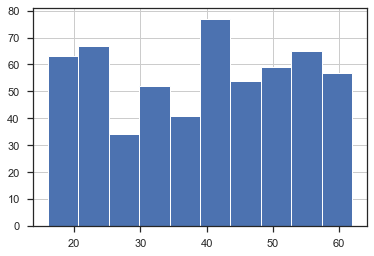

In [175]:
df['age'].hist()

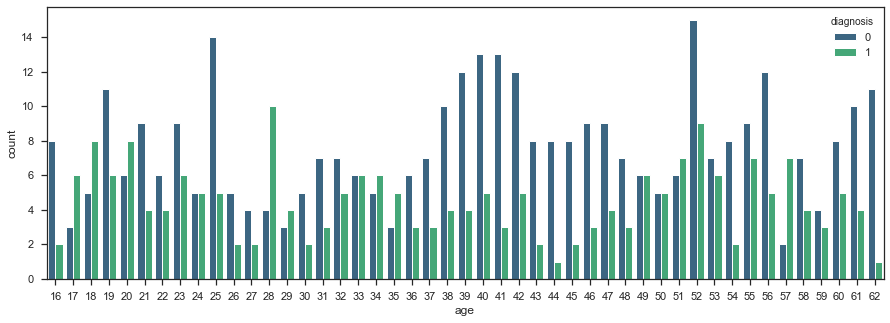

In [184]:
plt.figure(figsize=[15,5])
sns.countplot(x='age',hue='diagnosis',data=df,palette='viridis')

From the above two figure it is clear that most women got diagnosed with malignant tumor whenof age over 36

 Looking for patterns with all the  columns

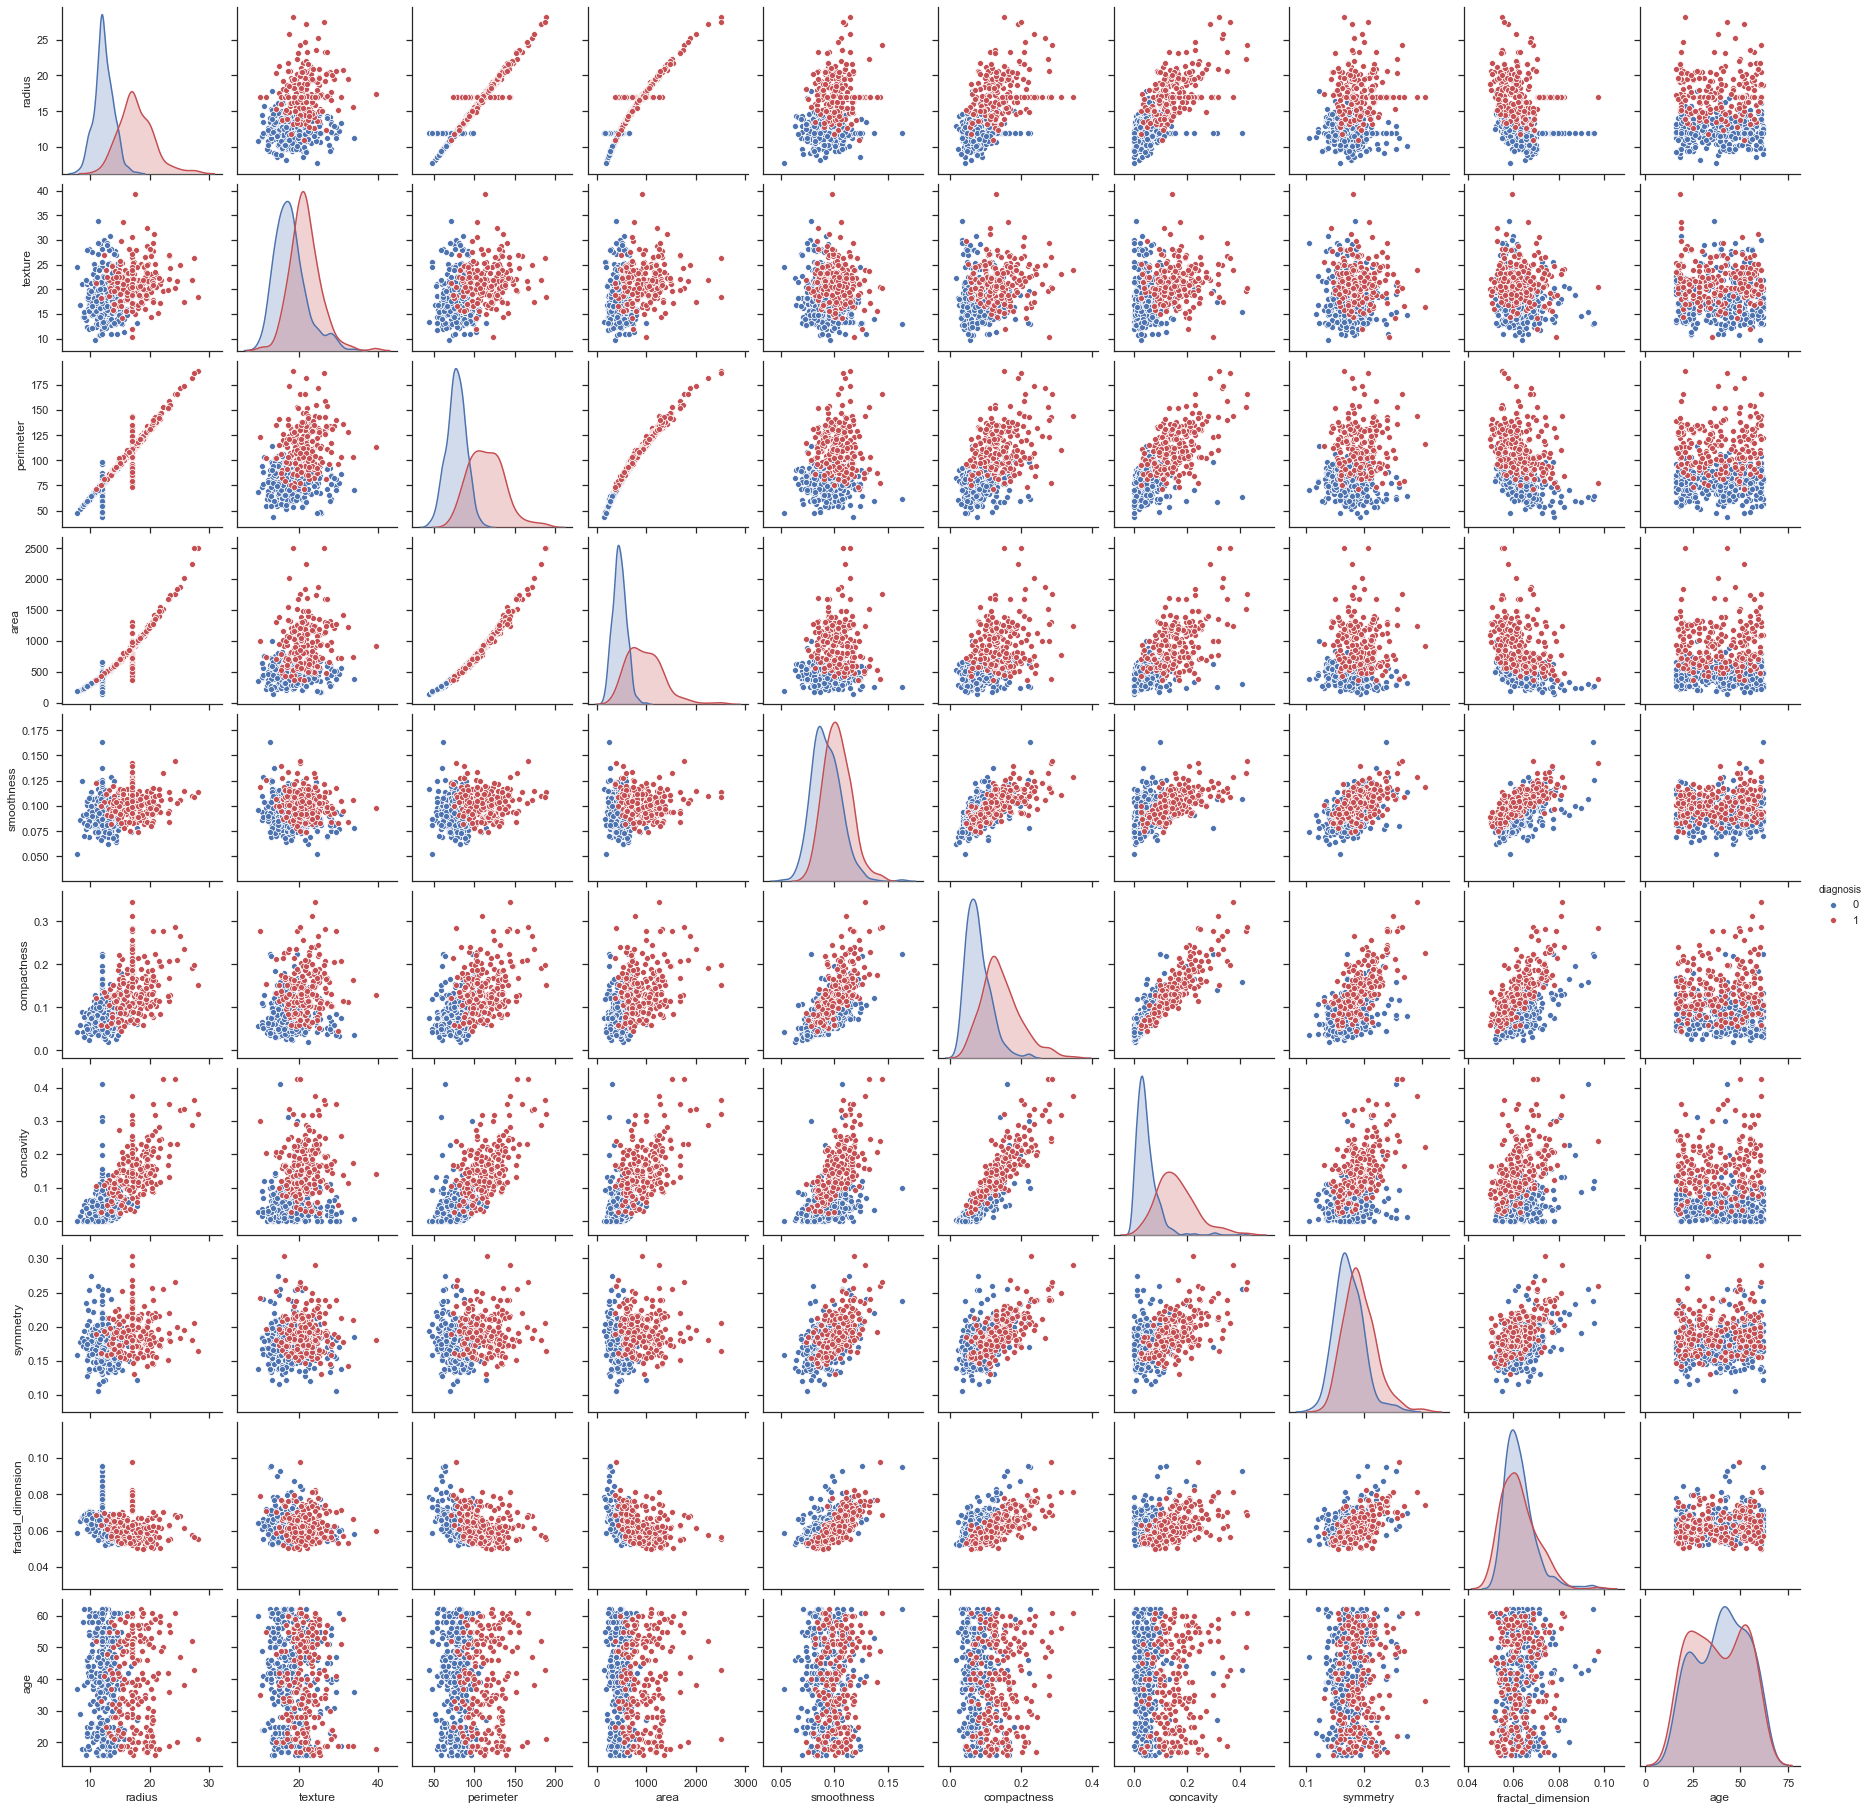

In [106]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df, palette = ('b', 'r'), hue="diagnosis", height=2.5)


There is perfect liniearity between radius,area and perimeter and for the same reason there could be multicollinarity present.Another set of variables that possibly imply multicollinearity are the concavity and compactness. 

#### Correlation between the variables

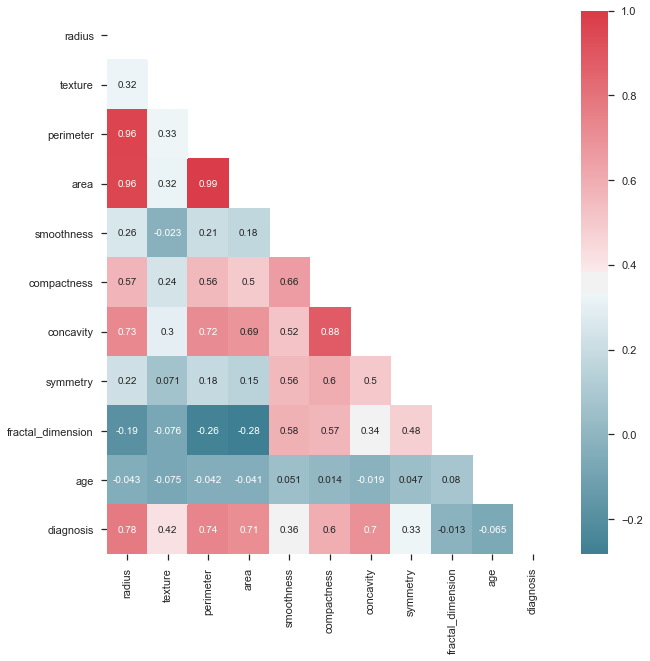

In [158]:
#computing correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Setting size for the plot
ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap,annot=True)

Here in this correlation matrix,area_mean,radius_mean,perimeter_mean ,have the correlation close to 1 and hence ,they are closely related and show multicolliliarity.This is probably because the three columns essentially contain the same information, which is the physical size of the observation (the cell).Therefore we should only pick one of the three columns when we go into further analysis.There is also close correlation between compactness and concavity.

For the model to not be biased at predicting ,we need to remove variables(more than one) that have a correlation >0.9.

#### Dropping of features with a correlation greater than 0.9
    

In [127]:
corr_matrix = df.corr().abs()

#select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [84]:
# Drop the redundant features from the df
df2 = df.drop(df[to_drop], axis=1)

In [128]:
df2.corr()

,radius,texture,smoothness,compactness,concavity,symmetry,fractal_dimension,age,diagnosis
radius,1.000000,0.324487,0.256036,0.571230,0.727264,0.219232,-0.186437,-0.043138,0.775940
texture,0.324487,1.000000,-0.023389,0.236702,0.302418,0.071401,-0.076437,-0.075189,0.415185
smoothness,0.256036,-0.023389,1.000000,0.659123,0.521984,0.557775,0.584792,0.051198,0.358560
compactness,0.571230,0.236702,0.659123,1.000000,0.883121,0.602641,0.565369,0.013898,0.596534
concavity,0.727264,0.302418,0.521984,0.883121,1.000000,0.500667,0.336783,-0.018575,0.696360
symmetry,0.219232,0.071401,0.557775,0.602641,0.500667,1.000000,0.479921,0.047098,0.330499
fractal_dimension,-0.186437,-0.076437,0.584792,0.565369,0.336783,0.479921,1.000000,0.080118,-0.012838
age,-0.043138,-0.075189,0.051198,0.013898,-0.018575,0.047098,0.080118,1.000000,-0.065279
diagnosis,0.775940,0.415185,0.358560,0.596534,0.696360,0.330499,-0.012838,-0.065279,1.000000



The column that was eliminated was the perimeter and area column


In [89]:
df2.shape

(569, 9)

Two columns have been dropped and now we have 569 rows but 9 columns

# Model building

Train test split data

In [159]:
X = df2.drop(['diagnosis'],axis=1)
y = df2['diagnosis']

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [161]:
X.shape

(569, 8)

In [162]:
#creating logistic regression object
lr = LogisticRegression()

#fitting model
lr.fit(X_train,y_train)

#predicting values of y
yhat=lr.predict(X_test)

In [163]:
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       108
           1       0.93      0.89      0.91        63

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



In [164]:

print(confusion_matrix(y_test,yhat))

[[104   4]
 [  7  56]]


We can see that 7  malignant cases have been classified incorrectly as benign (False negatives). Also, just 4 benign case has been classified as malignant (False positive).A false negative is not a good scenario during prediction as it concludes that a patient has been misdiagnosed ,when they acutally do have malignant tumor.A false positive is not so a big issue as a person with a benign tumor was lablled malignant,which would at most lead to incurring additional cost .

# GridSearch

We will now use GridSearch to lower the number of false negatives in the model

In [165]:
# Find best hyperparameters (accuracy)

param_grid = [
    {'penalty' : ['l2','l1','elasticnet','none'],  
     'C' : [0.001,.009,0.01,.09,1,5,10,25],
     'solver':['lbfgs','newton-cg','liblinear','sag','saga'],
     'max_iter':[100,1000,2500,5000]
    }
]

In [167]:

#Creating logistic regression object
lr=LogisticRegression()

CV_lr = GridSearchCV(estimator = lr, param_grid = param_grid ,cv=3,scoring = 'recall')

#fitting model
best_CV_lr=CV_lr.fit(X_train, y_train)

#Predicting values
y_acc = best_CV_lr.predict(X_test)

In [168]:
# New Model Evaluation metrics 
print(classification_report(y_test, y_acc))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       108
           1       0.92      0.94      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171



In [139]:
#confusion matrix 
print(confusion_matrix(y_test,y_acc))


[[103   5]
 [  3  60]]


we were able to reduce the number of false negativesto 3 with the help of hyperparameter tuning.

A classification report checks our model’s precision, recall, and F1 score. The support is the number of samples of the true response that lies in that class.
Precision and recall are not the same. Precision is the fraction of relevant results. Recall is the fraction of all relevant results that were correctly classified.
F1 score is the harmonic mean between precision and recall that ranges between 0 (terrible) to 1 (perfection).

# Conclusion

We had 171 women in our test set. Out of the 105 women predicted to not have breast cancer, 7 women were classified as not having breast cancer when they actually did (Type I error). Out of the 66 women predicted to have breast cancer, 10 were classified as having breast cancer when they did not (Type II error). In a nut shell, our model was more or less 95% accurate,the result is the output accuracy we got after hypterparameter tuning using GridSearch with reduced number of false negatives